In [1]:
import itertools
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
batch_sizes = 50


train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True, num_workers=2)


val_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_sizes, shuffle=False, num_workers=2)

In [3]:
data = iter(train_loader)

In [4]:
images, labels = data.next()

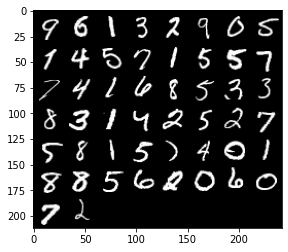

In [5]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
  
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
num_epochs = 20
learning_rate = 0.01

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [9]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0762, -0.0354, -0.0291, -0.0300,  0.0892,  0.1002,  0.0363, -0.0240,
         -0.0158,  0.0996],
        [ 0.0711, -0.0316, -0.0304, -0.0329,  0.0857,  0.1026,  0.0413, -0.0170,
         -0.0184,  0.0984],
        [ 0.0737, -0.0307, -0.0283, -0.0341,  0.0809,  0.1053,  0.0432, -0.0170,
         -0.0207,  0.1000],
        [ 0.0714, -0.0310, -0.0297, -0.0321,  0.0841,  0.1044,  0.0414, -0.0191,
         -0.0197,  0.0988],
        [ 0.0737, -0.0311, -0.0325, -0.0340,  0.0856,  0.1015,  0.0410, -0.0163,
         -0.0209,  0.1006],
        [ 0.0751, -0.0327, -0.0299, -0.0384,  0.0872,  0.1022,  0.0417, -0.0167,
         -0.0179,  0.0971],
        [ 0.0735, -0.0305, -0.0312, -0.0326,  0.0850,  0.1027,  0.0401, -0.0191,
         -0.0213,  0.1000],
        [ 0.0726, -0.0310, -0.0309, -0.0336,  0.0847,  0.1027,  0.0409, -0.0183,
         -0.0204,  0.0991],
        [ 0.0764, -0.0336, -0.0301, -0.0326,  0.0851,  0.0999,  0.0389, -0.0202,
         -0.0165,  0.0985],
        [ 0.0705, -

In [10]:
# Model instance
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [11]:
loss_list = []
count = 0

for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, batch_sizes)

    # store loss
    loss_list.append(train_running_loss / i)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.3964 | Train Accuracy: 86.90
Epoch:  1 | Loss: 0.1009 | Train Accuracy: 97.01
Epoch:  2 | Loss: 0.0687 | Train Accuracy: 97.99
Epoch:  3 | Loss: 0.0525 | Train Accuracy: 98.51
Epoch:  4 | Loss: 0.0425 | Train Accuracy: 98.76
Epoch:  5 | Loss: 0.0376 | Train Accuracy: 98.96
Epoch:  6 | Loss: 0.0326 | Train Accuracy: 99.10
Epoch:  7 | Loss: 0.0290 | Train Accuracy: 99.21
Epoch:  8 | Loss: 0.0249 | Train Accuracy: 99.31
Epoch:  9 | Loss: 0.0217 | Train Accuracy: 99.41
Epoch:  10 | Loss: 0.0201 | Train Accuracy: 99.45
Epoch:  11 | Loss: 0.0179 | Train Accuracy: 99.53
Epoch:  12 | Loss: 0.0165 | Train Accuracy: 99.57
Epoch:  13 | Loss: 0.0151 | Train Accuracy: 99.59
Epoch:  14 | Loss: 0.0123 | Train Accuracy: 99.69
Epoch:  15 | Loss: 0.0122 | Train Accuracy: 99.70
Epoch:  16 | Loss: 0.0124 | Train Accuracy: 99.69
Epoch:  17 | Loss: 0.0101 | Train Accuracy: 99.79
Epoch:  18 | Loss: 0.0095 | Train Accuracy: 99.80
Epoch:  19 | Loss: 0.0105 | Train Accuracy: 99.73


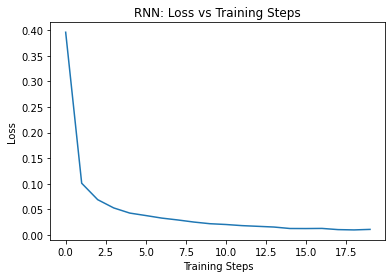

In [12]:
# visualization loss 
x_range = range(len(loss_list))
plt.plot(x_range,loss_list)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Training Steps")
plt.show()

In [14]:
val_acc = 0.0
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    val_acc += get_accuracy(outputs, labels, batch_sizes)
        
print('Val Accuracy: %.2f'%(val_acc/i))

Val Accuracy: 99.27
